In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [54]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import corner
import h5py
from matplotlib.colors import LogNorm
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture
import seaborn as sns
import sys
from tqdm import tqdm

d = "/Users/wfarr/Research/CBCPopulation/O2Populations/code"
try:
    sys.path.index(d)
except ValueError:
    sys.path.append(d)
    
import vt

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

In [3]:
BBHs = ['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729',  'GW170809', 'GW170814', 'GW170818', 'GW170823']

In [4]:
m1s = []
m2s = []
dls = []
for b in BBHs:
    with h5py.File('./GWTC-1/GWTC-1_sample_release/'+b+'_GWTC-1.hdf5', 'r') as f:
        m1s.append(array(f['Overall_posterior']['m1_detector_frame_Msun']))
        m2s.append(array(f['Overall_posterior']['m2_detector_frame_Msun']))
        dls.append(array(f['Overall_posterior']['luminosity_distance_Mpc']))
        
wts = []
for d in dls:
    wts.append(1.0/(d*d))

In [5]:
m1s_re = []
m2s_re = []
dls_re = []
for m1, m2, dl, wt in zip(m1s, m2s, dls, wts):
    wmax = np.max(wt)
    rs = random.uniform(low=0, high=wmax, size=len(m1))
    sel = rs < wt
    
    m1s_re.append(m1[sel])
    m2s_re.append(m2[sel])
    dls_re.append(dl[sel])
lmin = np.min([len(x) for x in m1s_re])

In [6]:
m1s_out = []
m2s_out = []
dls_out = []
for m1, m2, dl in zip(m1s_re, m2s_re, dls_re):
    p = random.choice(len(m1), size=lmin, replace=False)
    m1s_out.append(m1[p])
    m2s_out.append(m2[p])
    dls_out.append(dl[p])
m1s_out = array(m1s_out)
m2s_out = array(m2s_out)
dls_out = array(dls_out)

Text(0, 0.5, '$p(z)$')

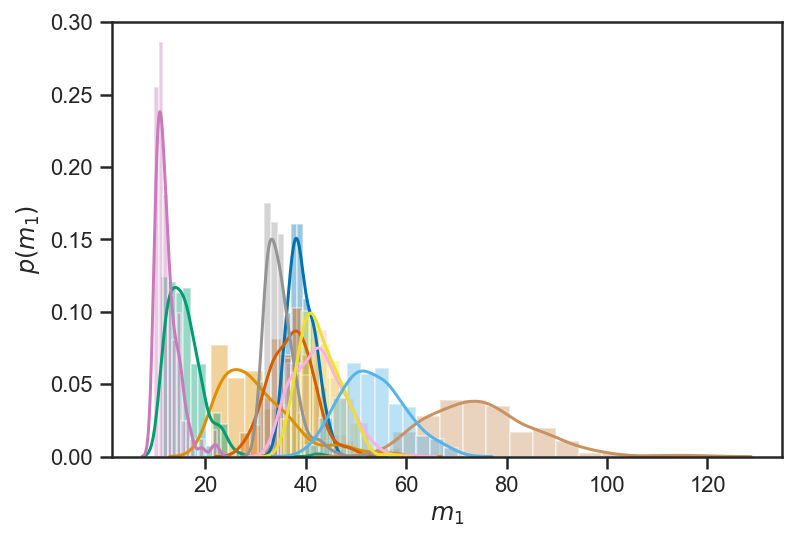

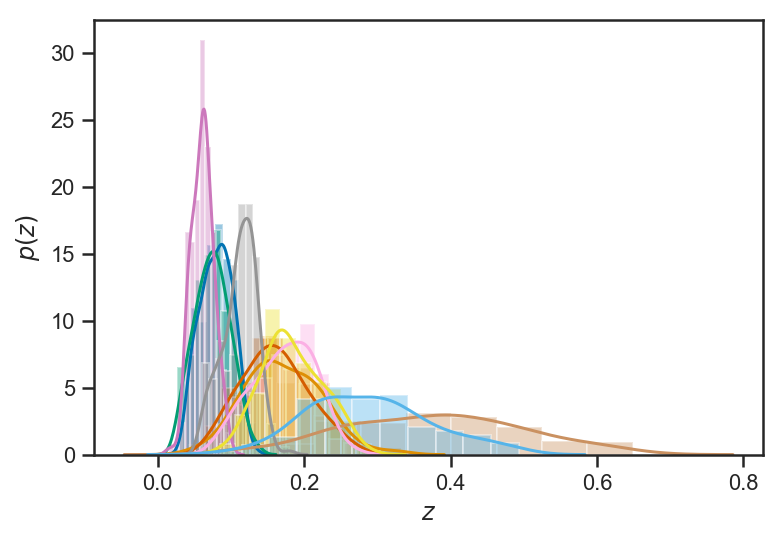

In [7]:
for m1 in m1s_out:
    sns.distplot(m1)
xlabel(r'$m_1$')
ylabel(r'$p\left( m_1 \right)$')

z = linspace(0, 2, 1000)
d = Planck15.luminosity_distance(z).to(u.Mpc).value
z_of_d = interp1d(d, z)

figure()
for dl in dls_out:
    sns.distplot(z_of_d(dl))
xlabel(r'$z$')
ylabel(r'$p(z)$')

In [8]:
with h5py.File('GWTC-1/GWTC-1-observations.h5', 'w') as f:
    g = f.create_group('posteriors')
    g.create_dataset('m1det', data=m1s_out, compression='gzip', shuffle=True)
    g.create_dataset('m2det', data=m2s_out, compression='gzip', shuffle=True)
    g.create_dataset('dl', data=dls_out/1000, compression='gzip', shuffle=True)

    f.attrs['Tobs'] = 169.7/365.25

Now we make the "injection" set that we need to estimate VT for this population.  We do this by constructing a number of KDEs from the observed population, but in a parameter space that is unconstrained (we use a number of KDEs to average over the posterior while still incorporating uncertainty about the detected population).

In [17]:
kdes = []

x = log(m1s_out) # Always positive
y = log(m2s_out) - log(m1s_out-m2s_out) # 0 < m2 < 1
z = log(dls_out/1000) # Gpc

for i in range(25):
    xx = [random.choice(x[i,:]) for i in range(x.shape[0])]
    yy = [random.choice(y[i,:]) for i in range(y.shape[0])]
    zz = [random.choice(z[i,:]) for i in range(z.shape[0])]
    
    kdes.append(gaussian_kde(row_stack((xx, yy, zz))))
    

def draw_and_wt():
    l = len(kdes)
    i = randint(l)
    
    xx, yy, zz = kdes[i].resample(1)
    
    m1 = exp(xx)
    dl = exp(zz)
    m2 = m1*exp(yy)/(1+exp(yy))
    
    ps = mean([k([xx,yy,zz]) for k in kdes])
    jac = 1.0/m1 * (1.0/m2 + 1.0/(m1-m2)) * 1.0/dl
    
    return m1, m2, dl, ps*jac

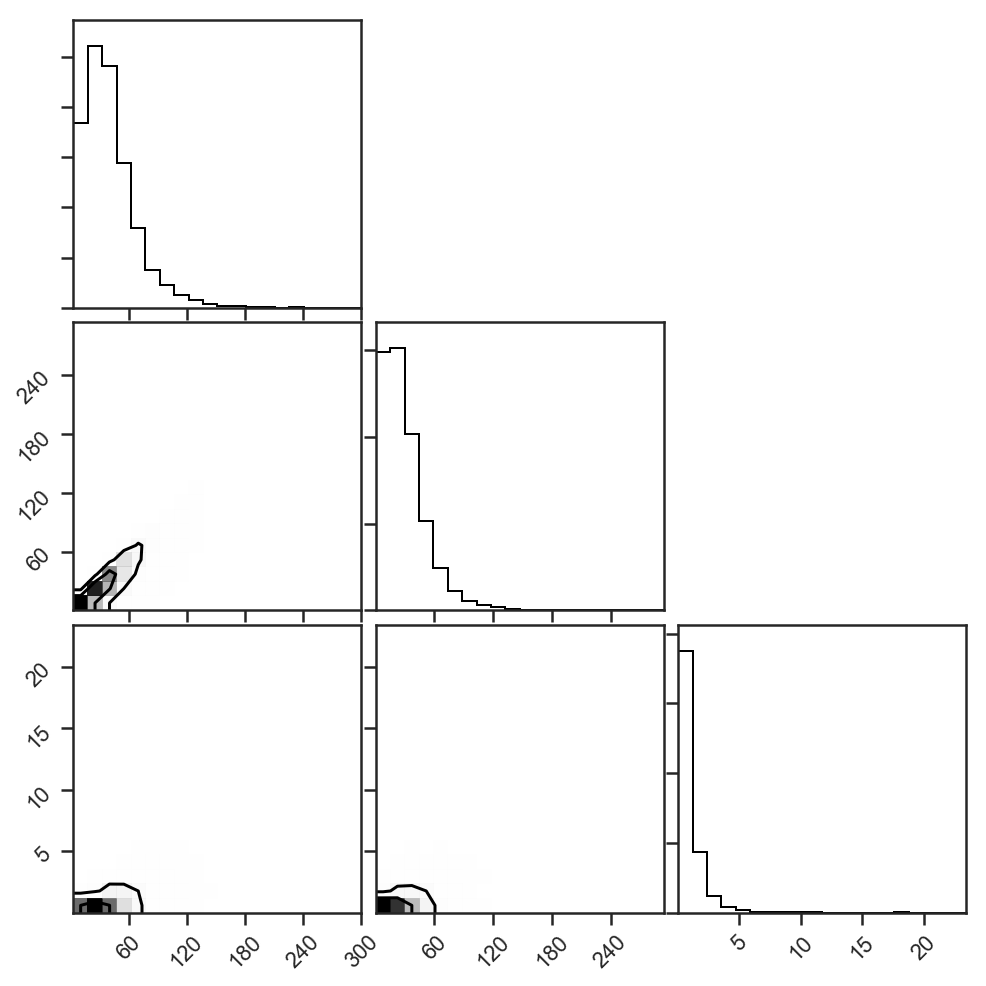

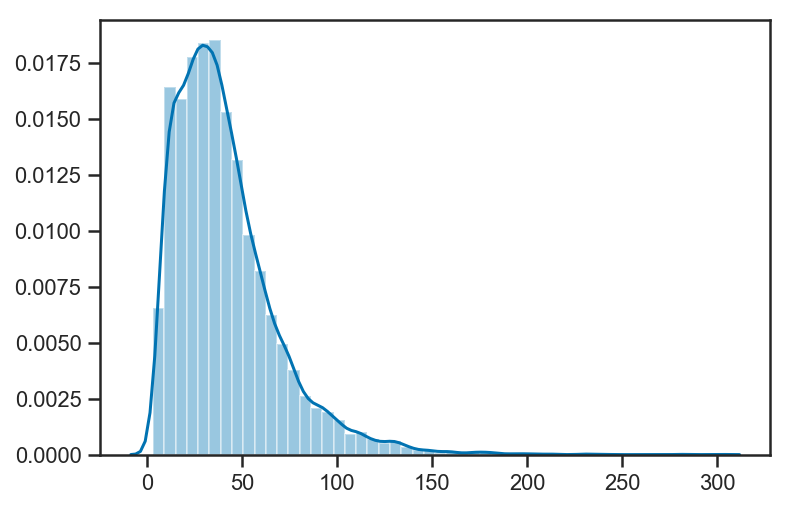

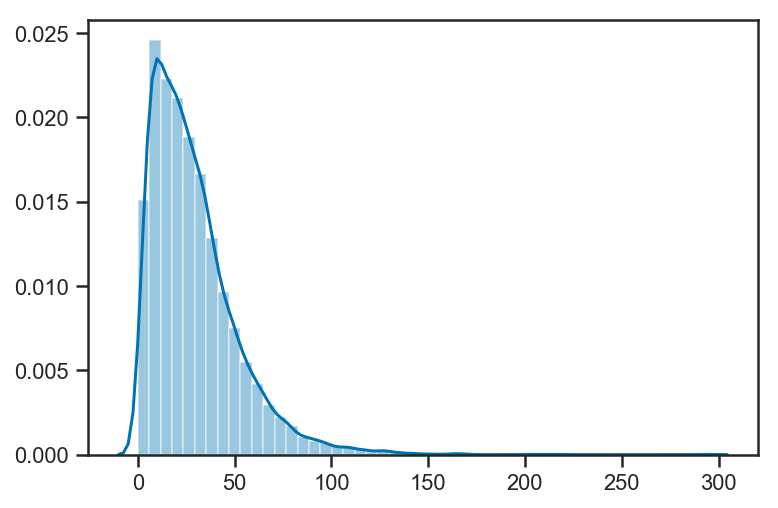

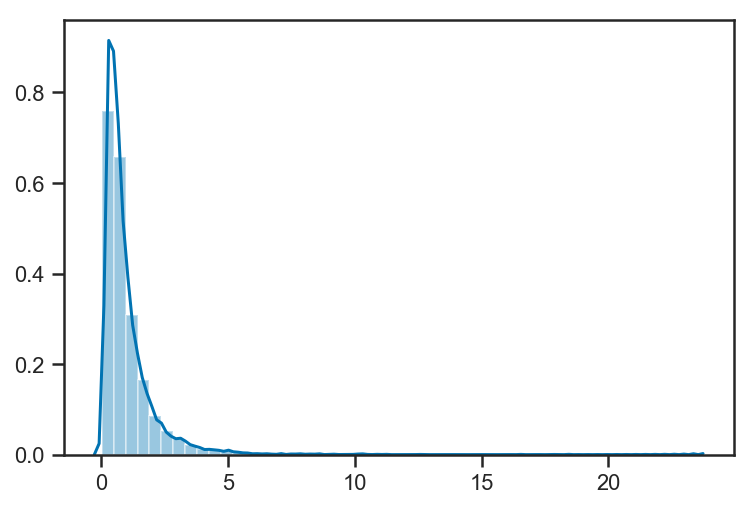

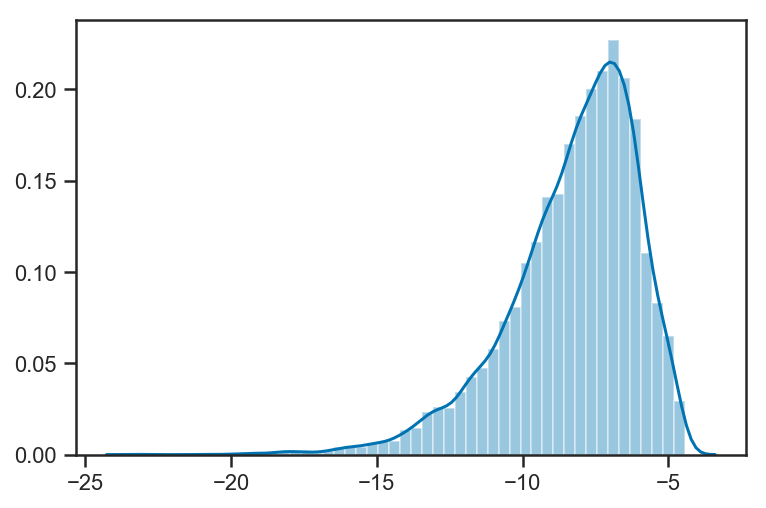

In [59]:
draws = squeeze(array([draw_and_wt() for i in range(10000)]))
corner.corner(draws[:,:3], plot_datapoints=False)
figure()
sns.distplot(draws[:,0])
figure()
sns.distplot(draws[:,1])
figure()
sns.distplot(draws[:,2])
figure()
sns.distplot(log(draws[:,3]))

In [62]:
Ngen = 0
Ninj_det = 2048
snr_thresh = 6

m1sel = []
m2sel = []
dlsel = []
wtsel = []

with tqdm(total=Ninj_det) as bar:
    while len(m1sel) < Ninj_det:
        m1, m2, dl, wt = draw_and_wt()
        
        z = cosmo.z_at_value(Planck15.luminosity_distance, dl*u.Gpc)
        
        m1 = float(m1)
        m2 = float(m2)
        dl = float(dl)
        z = float(z)
        
        pd = vt.fraction_above_threshold(m1/(1+z), m2/(1+z), z, snr_thresh, psd_fn=vt.ls.SimNoisePSDaLIGOEarlyHighSensitivityP1200087)
        
        if rand() < pd:
            m1sel.append(m1)
            m2sel.append(m2)
            dlsel.append(dl)
            wtsel.append(wt)
            
            bar.update(1)
        
        Ngen += 1

100%|██████████| 2048/2048 [01:00<00:00, 33.63it/s]


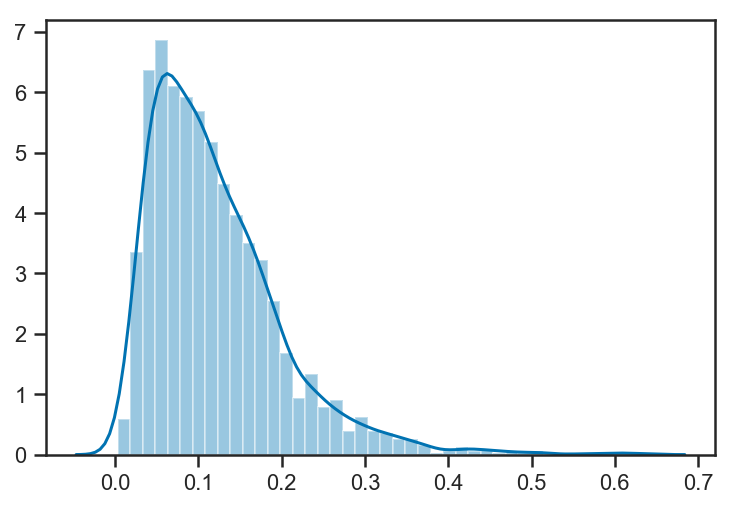

In [63]:
sns.distplot(z_of_d(array(dlsel)*1000))

In [64]:
with h5py.File('GWTC-1/GWTC-1-selected.h5', 'w') as f:
    f.attrs['N_gen'] = Ngen
    f.create_dataset('m1det', data=m1sel, compression='gzip', shuffle=True)
    f.create_dataset('m2det', data=m2sel, compression='gzip', shuffle=True)
    f.create_dataset('dl', data=dlsel, compression='gzip', shuffle=True)
    f.create_dataset('wt', data=wtsel, compression='gzip', shuffle=True)

In [65]:
print('Number generated = {:d}'.format(Ngen))

Number generated = 3897


Now let's check how many GMM components we need for this population.

In [70]:
ngs = []
scores = []
for ng in tqdm(range(1, 7)):
    gmm = GaussianMixture(ng)
    s = []
    for m1, m2, dl in zip(m1s_out, m2s_out, dls_out/1000):
        N = m1.shape[0]
        p = random.permutation(N)
        N2 = N//2
        
        train_pts = column_stack((m1[p][:N2], m2[p][:N2], dl[p][:N2]))
        test_pts = column_stack((m1[p][N2:], m2[p][N2:], dl[p][N2:]))
        
        gmm.fit(train_pts)
        
        s.append(gmm.score(test_pts))
    scores.append(s)
    ngs.append(ng)
scores = array(scores)
ngs = array(ngs)

100%|██████████| 6/6 [00:00<00:00,  9.21it/s]


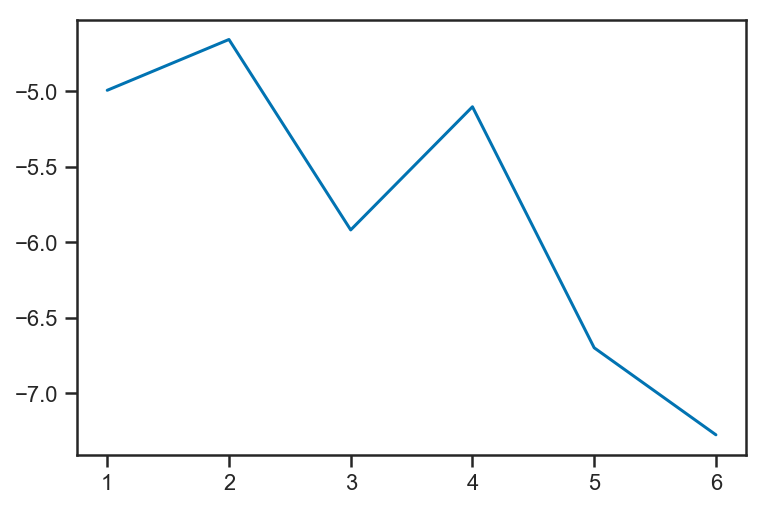

In [71]:
plot(ngs, mean(scores, axis=1))

In [72]:
ngs[argmax(mean(scores, axis=1))]

2